# Prerequisites

This notebook demonstrates why Saturn Cloud is the solution for running ML tools against a large industrial dataset and getting results quickly. 

**I am running this project with the following parameters. I reccommend setting up a server with these settings before proceeding**:
```XLarge - 4 cores - 32 GB RAM - 256G Disk```

# Get the (big) data 

Let's load up a 50 TB file of wind data provided from Amazon Web Services. In order to get this data, we need to use the [HDF](https://www.hdfgroup.org/2015/04/hdf5-for-the-web-hdf-server) Group's Highly Scalable Data Service (HSDS). Request an API key from https://developer.nrel.gov/signup/. You'll receive an email containing your key. 

# Once you've launched a Jupyter Notebook from your server 
(how to launch [JupyterLab notebook]('http://docs.saturncloud.io/en/articles/3650879-starting-jupyter') in Saturn in case you have not)

From your notebook, you can launch a new terminal by:

```file > new > terminal```

Then execute the following commands:

Install h5pyd

```$ pip install --user git+http://github.com/HDFGroup/h5pyd.git```

Configure HDF Cloud client

```$ hsconfigure```

Then you will be prompted to configuration details:

```$ hs_endpoint = https://developer.nrel.gov/api/hsds```

```$ hs_username = type_your_email_here.com```

```$ hs_password = type_your_password```

```$ hs_api_key = paste_your_key```

# Quick EDA 

#### **note if any of these imports cannot be located, just pip install the same way you did with h5pyd above


In [4]:

# misc imports 
import h5pyd
import pandas as pd, numpy as np
from pathlib import Path
from datetime import *
import dateutil.parser
import collections
import time
# import tables

# DASK imports
from dask.distributed import Client
from dask import delayed
import dask.array as da, dask.dataframe as dd
from distributed import Client
from dask_saturn import SaturnCluster

# data viz
import bokeh.plotting
import datashader as ds
from colorcet import fire
from datashader import transfer_functions as tf
from datashader.utils import lnglat_to_meters
from holoviews.plotting.util import process_cmap


import holoviews as hv
from holoviews.element.tiles import EsriImagery
from holoviews import opts
from holoviews.operation.datashader import datashade, spread
from holoviews.element import tiles
hv.extension('bokeh')



In [5]:
# load wind data 
f = h5pyd.File("/nrel/wtk-us.h5", 'r')  

In [6]:
# list the datasets in our file
list(f)

['inversemoninobukhovlength_2m',
 'status',
 'windspeed_10m',
 'temperature_80m',
 'temperature_160m',
 'temperature_200m',
 'pressure_200m',
 'DIF',
 'temperature_10m',
 'winddirection_120m',
 'windspeed_120m',
 'windspeed_140m',
 'temperature_60m',
 'relativehumidity_2m',
 'windspeed_200m',
 'temperature_140m',
 'precipitationrate_0m',
 'winddirection_160m',
 'pressure_0m',
 'GHI',
 'windspeed_80m',
 'winddirection_100m',
 'temperature_2m',
 'temperature_40m',
 'coordinates',
 'winddirection_60m',
 'windspeed_160m',
 'winddirection_40m',
 'winddirection_10m',
 'DNI',
 'winddirection_200m',
 'windspeed_60m',
 'datetime',
 'pressure_100m',
 'windspeed_40m',
 'temperature_120m',
 'windspeed_100m',
 'winddirection_140m',
 'temperature_100m',
 'winddirection_80m']

In [11]:
temp = f['temperature_120m']
temp.shape

(61368, 1602, 2976)

In [8]:
temp.shape[0] * temp.shape[1] * temp.shape[2] * 4 * 10**-12 

1.170300524544

Each one of our datasets is a 3-dimensional array approximately 1 TB in size. 
We will better visualize these arrays using dask delayed in the Dask section. 

Let's queue up some additional features to temp. 

In [18]:
winddir = f['winddirection_120m']
windspd = f['windspeed_120m']
pres = f['pressure_100m']
DNI = f['DNI']
GHI = f['GHI']
dt = f['datetime']

Let's set our datetime as our index, and convert to a pandas dataframe for convenience:

In [32]:
master_df = pd.DataFrame({"datetime": dt[:]},index=range(0,dt.shape[0]))
master_df['datetime'] = master_df['datetime'].apply(dateutil.parser.parse)
master_df.head()

,datetime
0,2007-01-01 00:00:00
1,2007-01-01 01:00:00
2,2007-01-01 02:00:00
3,2007-01-01 03:00:00
4,2007-01-01 04:00:00


Now I want to focus on a single location, and combine some of my other features into master_df, which is only datetime so far 

In [33]:
%time master_df['winddir'] = winddir[:,42,42]
%time master_df['windspd'] = windspd[:,42,42]
%time master_df['pres'] = pres[:,42,42]
%time master_df['DNI'] = DNI[:,42,42]
%time master_df['GHI'] = GHI[:,42,42]
%time master_df['temp'] = temp[:,42,42]

CPU times: user 13 ms, sys: 3.67 ms, total: 16.6 ms
Wall time: 10 s
CPU times: user 15.4 ms, sys: 869 µs, total: 16.2 ms
Wall time: 9.8 s
CPU times: user 16.1 ms, sys: 238 µs, total: 16.4 ms
Wall time: 9.45 s
CPU times: user 11.2 ms, sys: 4.27 ms, total: 15.5 ms
Wall time: 9 s
CPU times: user 16.4 ms, sys: 260 µs, total: 16.7 ms
Wall time: 10 s
CPU times: user 16.6 ms, sys: 274 µs, total: 16.9 ms
Wall time: 9.57 s


In [34]:
master_df.head()

,datetime,winddir,windspd,pres,DNI,GHI,temp
0,2007-01-01 00:00:00,65.672783,9.808647,100788.593750,632.145142,321.359894,290.781891
1,2007-01-01 01:00:00,58.383133,9.317299,100754.718750,112.613281,88.740173,290.678131
2,2007-01-01 02:00:00,58.108459,10.177925,100796.835938,0.000000,0.000000,290.665924
3,2007-01-01 03:00:00,54.955292,11.041595,100837.125000,0.000000,0.000000,290.589630
4,2007-01-01 04:00:00,55.444199,8.822899,100864.593750,0.000000,0.000000,290.559082


In [35]:
# Extract coordinates (lat, lon)
coords = f['coordinates']

In [508]:
len(coords)

1602

# Faster with DASK 

It's really easy to spin up a [Dask Cluster in Saturn](http://docs.saturncloud.io/en/articles/3652101-spin-up-dask-on-saturn), and add/subtract workers using the GUI below

In [13]:
cluster = SaturnCluster()
cluster

In [59]:
client = Client(cluster)

Remember to spin down your cluster when you are done working! Just uncomment the cell below 

In [ ]:
# cluster.close()

We can confirm our cluter is running, you should see 'running'  

In [15]:
cluster.status

'running'

I'm really interested in wind speed, but visualizing that 3-dimensional array the way we did at the top of this notebook wasn't intuitive. Using dask array, you can write a bit less code and the array itself is easier to interpret:

In [22]:
da_windspd = da.array(windspd)
da_windspd

,Array,Chunk
Bytes,1.17 TB,101.71 MB
Shape,"(61368, 1602, 2976)","(96, 356, 744)"
Count,12801 Tasks,12800 Chunks
Type,float32,numpy.ndarray


Compared this visual representation of our 3-dimensional array to the initial EDA at the top of this notebook. This is much clearer. Above is a lazy 3-dimensional Dask array. Dask arrays are composed of many chunks of data. You can learn more about Dask arrays [here](https://blog.dask.org/2019/06/20/load-image-data), and explore the API using tab complete (see screenshot below) 

![](https://raw.githubusercontent.com/sami2ahmed/energy/master/Screen%20Shot%202020-05-02%20at%202.35.18%20PM.png)



# Static Visualization 

I want to visualize features having to do with temperatures because turbines in our southern regions seem to have more failures. I'm going to do this section using Dask's datashader. Datashader **can plot a billion points in a second or so on a 16GB laptop**, and scales up easily to out-of-core,  distributed, or GPU processing for even larger datasets. 

One important caveat to remember, does not support datetimes directly so we create a new column casting the datetimes to integer

In [ ]:
master_df['ITime'] = pd.to_datetime(master_df['datetime']).astype('int64')

In [ ]:
# if you are concerned about memory, you can start by downsampling data to a day, but your machine should be fine
# if you chose to downsample note you need to change out master_df for daily_df 
# daily_df = master_df.iloc[::24, :]

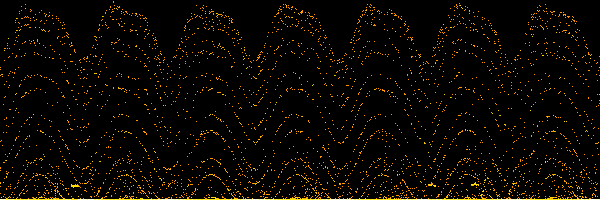

In [519]:
# GHI is global horizontal irradiance, a type of radiation from the sun 
agg = ds.Canvas(plot_height=200).points(master_df, 'ITime', 'GHI')
tf.set_background(tf.shade(agg, cmap=fire),"black")

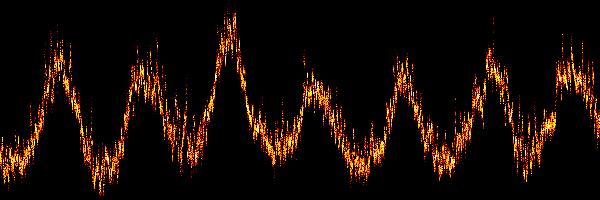

In [492]:
agg = ds.Canvas(plot_height=200).points(master_df, 'ITime', 'temp')
tf.set_background(tf.shade(agg, cmap=fire),"black")

This is of course just stratching the surface of Datashader but two reasons it's great: 
1. only a few lines of code (in contrast to a lot of plotting APIs that are really verbose) 
2. it handles tons of data with ease 

# Faster with Dask (Solar dataset) 

Let's load up a solar dataset also provided from Amazon Web Services. We can load up this data immediately using the same API key that we got above. This dataset can give me more insight into GHI but this time we will superimpose on an interactive map 

In [3]:
s = h5pyd.File("/nrel/nsrdb/nsrdb_2012.h5", 'r')

In [39]:
# Extract coordinates (lat, lon)
print(dict(s['coordinates'].attrs))
coords = s['coordinates'][...]

Let's evaluate global horizontal irradiance to get more insight into how effectively our solar panels have been operating 

In [5]:
list(s)

['air_temperature',
 'alpha',
 'aod',
 'asymmetry',
 'cld_opd_dcomp',
 'cld_reff_dcomp',
 'clearsky_dhi',
 'clearsky_dni',
 'clearsky_ghi',
 'cloud_press_acha',
 'cloud_type',
 'coordinates',
 'dew_point',
 'dhi',
 'dni',
 'fill_flag',
 'ghi',
 'meta',
 'ozone',
 'relative_humidity',
 'solar_zenith_angle',
 'ssa',
 'surface_albedo',
 'surface_pressure',
 'time_index',
 'total_precipitable_water',
 'wind_direction',
 'wind_speed']

In [5]:
dset = s['ghi']
dset.shape

(17568, 2018392)

In [6]:
coords[:, 0].shape

(2018392,)

In [38]:
# To convert dataset values back to floats use the 'psm_scale_factor'
# global horizontal irradiance has been truncated to integer precision
dset.attrs['psm_scale_factor'] 

I'll quickly show how to convert a Pandas dataframe over to Dask, in order to perform the simple scaling division for GHI. 

**NOTE I tried doing the scaling in Pandas, and my kernel died**

In [9]:
%time sdf = pd.DataFrame() # Combine data with coordinates in a DataFrame
%time sdf['longitude'] = coords[:, 1]
%time sdf['latitude'] = coords[:, 0]
%time sdf['ghi'] = s['ghi'][0,:]

CPU times: user 397 µs, sys: 48 µs, total: 445 µs
Wall time: 452 µs
CPU times: user 110 ms, sys: 32.3 ms, total: 142 ms
Wall time: 141 ms
CPU times: user 2.73 ms, sys: 0 ns, total: 2.73 ms
Wall time: 2.74 ms
CPU times: user 45.9 ms, sys: 9.18 ms, total: 55.1 ms
Wall time: 15.5 s


In [10]:
# very easily switch over to dask dataframe using 'from_pandas'
%time sdd = dd.from_pandas(sdf, npartitions=3)

CPU times: user 52 ms, sys: 3.99 ms, total: 56 ms
Wall time: 55.1 ms


In [11]:
# unscale dataset, this is the operation that killed my kernel 
sdd['ghi_scaled'] = sdd['ghi'] / dset.attrs['psm_scale_factor']

In [13]:
# really easy to run many of the same methods as you would on a Pandas dataframe 
sdd.head(2)

,longitude,latitude,ghi,ghi_scaled
0,-175.259995,-19.99,1058,1058.0
1,-175.220001,-19.99,1057,1057.0


This operation of translating GHI to a float is a simplistic example, but nonetheless a real world example of Dask being used to avoid a kernel failure, using a real world large industrial dataset

# Interactive Visualization 

Datashader intergrates well with Bokeh, HoloViews, and GeoViews, so given the coordinates in our solar dataset, I can easily generate an interactive map 

In [22]:
# convert lat/lon to web mercator so datashade can setup the map 
wm_lon,wm_lat = lnglat_to_meters(sdd['longitude'],sdd['latitude'])
sdd['wm_lon'],sdd['wm_lat'] = wm_lon,wm_lat

In [37]:
# map laying out our location data 
map_tiles  = EsriImagery().opts(alpha=3, width=900, height=480, bgcolor='white')
points     = hv.Points(sdd, ['wm_lon', 'wm_lat'],)
ghi_index = datashade(points,cmap=process_cmap("Magma", provider="bokeh"), width=900, height=480)


map_tiles * ghi_index


:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .RGB.I   :RGB   [wm_lon,wm_lat]   (R,G,B,A)